In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import BertTokenizer, BertModel
from PIL import Image
import json
from torchvision.transforms.functional import to_tensor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Tokenizer and BERT model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()

# Image transformation
image_transform = transforms.Compose([
    transforms.Resize((224, 224)), # pads or shrinks the image to 224*224
    transforms.ToTensor(),
])

In [3]:
# MMF dataset class
class MmfDataset(Dataset):
    def __init__(self, data, image_folder, image_transform, tokenizer):
        self.data = data
        self.image_folder = image_folder
        self.image_transform = image_transform
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]

        # Load and preprocess image
        image_path = self.image_folder + entry["image"]
        image = Image.open(image_path).convert("RGB")
        image = self.image_transform(image)

        # Tokenize and obtain text embeddings using BERT
        text = entry["text"]
        tokens = self.tokenizer(text, return_tensors='pt', truncation=True, padding=True)
        with torch.no_grad():
            text_embedding = bert_model(**tokens).last_hidden_state.mean(dim=1)

        # Label encoding
        label = entry["labels"][0]
        if label == "not harmful":
            encoded_label = 0
        elif label == "somewhat harmful":
            encoded_label = 1
        elif label == "very harmful":
            encoded_label = 2

        # Convert encoded_label to a PyTorch tensor
        encoded_label_tensor = torch.tensor(encoded_label)

        return image, text_embedding, encoded_label_tensor

In [4]:
def collate_fn(batch):
    # Unpack the batch into separate lists for images, text_embeddings, and labels
    images, text_embeddings, labels = zip(*batch)

    # Stack images and text_embeddings into tensors
    images = torch.stack(images)
    text_embeddings = torch.stack(text_embeddings)

    # Stack labels into a tensor
    labels = torch.stack(labels)

    return images, text_embeddings, labels

In [5]:
train_dataset_path = "C:\\Users\\aysen\\Documents\\GitHub\\harmful_meme_models\\data\\datasets\\memes\\defaults\\annotations\\train.jsonl"
test_dataset_path = "C:\\Users\\aysen\\Documents\\GitHub\\harmful_meme_models\\data\\datasets\\memes\\defaults\\annotations\\test.jsonl"
image_folder = "C:\\Users\\aysen\\Documents\\GitHub\\harmful_meme_models\\data\\datasets\\memes\\defaults\\images\\"

# Read the JSON string for training dataset from the file
with open(train_dataset_path, "r", encoding='cp437') as file:
    train_dataset_str = file.read()
    file.close()

# Read the JSON string for test dataset from the file
with open(test_dataset_path, "r", encoding='cp437') as file:
    test_dataset_str = file.read()
    file.close()

# Parse the JSON string
train_dataset = [json.loads(entry) for entry in train_dataset_str.strip().split('\n')]
test_dataset = [json.loads(entry) for entry in test_dataset_str.strip().split('\n')]

# Split the training set into training and validation sets
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.2, random_state=42)

# Create DataLoader instances for both training and validation sets
mmf_dataset_train = MmfDataset(data=train_dataset, image_folder=image_folder, image_transform=image_transform, tokenizer=tokenizer)
data_loader_train = DataLoader(mmf_dataset_train, batch_size=32, shuffle=True, collate_fn=collate_fn)

mmf_dataset_val = MmfDataset(data=val_dataset, image_folder=image_folder, image_transform=image_transform, tokenizer=tokenizer)
data_loader_val = DataLoader(mmf_dataset_val, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Create DataLoader for the test set
mmf_dataset_test = MmfDataset(data=test_dataset, image_folder=image_folder, image_transform=image_transform, tokenizer=tokenizer)
data_loader_test = DataLoader(mmf_dataset_test, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [6]:
# Model definition
class MmfClassifier(nn.Module):
    
    def __init__(self, image_feature_size, text_feature_size, num_classes):
        
        super(MmfClassifier, self).__init__()
        self.shared_layer = nn.Linear(image_feature_size + text_feature_size, 256)
        self.dropout = nn.Dropout(0.25)
        self.relu = nn.LeakyReLU()
        self.output_layer = nn.Linear(256, num_classes)

    def forward(self, image_data, text_data):

        # Reshape to (batch_size, channels*height*width)
        flattened_image_data = image_data.view(image_data.size(0), -1)

        # Reshape to (batch_size, sequence_length*embedding_size)
        flattened_text_data = text_data.view(text_data.size(0), -1)

        # Combine visual and textual features 
        combined_features = torch.cat((flattened_image_data, flattened_text_data), dim=1)
        shared_output = self.relu(self.shared_layer(combined_features))
        x = self.dropout(shared_output)
        output = self.output_layer(x)

        return output

In [7]:
# Hyperparameters
image_feature_size = 3*224*224 # Image feature size
text_feature_size = 768  # Text feature size
num_classes = 3  # Number of classes

# Instantiate the model
model = MmfClassifier(image_feature_size, text_feature_size, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-5)

In [8]:
print("First entry in the dataset:")
print(json.dumps(train_dataset[0], indent=2))

First entry in the dataset:
{
  "id": "covid_memes_4257",
  "image": "covid_memes_4257.png",
  "labels": [
    "not harmful"
  ],
  "text": "rCONTROVERSYEy\n"
}


In [9]:
# Hyperparameters for training
num_epochs = 100
patience = 5  # Number of epochs with no improvement after which training will be stopped
best_val_loss = float('inf')
current_patience = 0

avg_train_losses = []
avg_val_losses = []

# Training and Validation loops
for epoch in range(num_epochs):

    train_losses = []
    val_losses = []
    
    # Training loop
    model.train()
    for batch in data_loader_train:
        images, text_embeddings, labels = batch
        outputs = model(images, text_embeddings)
        loss = criterion(outputs, labels)
        train_losses.append(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():
        
        for batch_val in data_loader_val:
            images_val, text_embeddings_val, labels_val = batch_val
            outputs_val = model(images_val, text_embeddings_val)
            val_loss = criterion(outputs_val, labels_val)
            val_losses.append(val_loss)

            _, predicted = torch.max(outputs_val, 1)
            correct_predictions += (predicted == labels_val).sum().item()
            total_samples += labels_val.size(0)
   
    # Print average training & val loss for the epoch
    avg_train_loss = sum(train_losses) / len(train_losses)
    avg_train_losses.append(avg_train_loss.item())
    
    avg_val_loss = sum(val_losses) / len(val_losses)
    avg_val_losses.append(avg_val_loss.item())
    
    accuracy = correct_predictions / total_samples
    
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}, Validation Accuracy: {accuracy}")

    # Check for early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        current_patience = 0
        # Save the model if needed
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        current_patience += 1

    if current_patience >= patience:
        print(f"Early stopping after {epoch} epochs without improvement.")
        break


Epoch 1/100, Training Loss: 0.9222849607467651, Validation Loss: 0.863269031047821, Validation Accuracy: 0.6417910447761194
Epoch 2/100, Training Loss: 0.8369672894477844, Validation Loss: 0.8423066139221191, Validation Accuracy: 0.6417910447761194
Epoch 3/100, Training Loss: 0.8200293779373169, Validation Loss: 0.8376997113227844, Validation Accuracy: 0.6417910447761194
Epoch 4/100, Training Loss: 0.8140237331390381, Validation Loss: 0.8368929624557495, Validation Accuracy: 0.6417910447761194
Epoch 5/100, Training Loss: 0.8098806142807007, Validation Loss: 0.8371375203132629, Validation Accuracy: 0.6417910447761194
Epoch 6/100, Training Loss: 0.8110998272895813, Validation Loss: 0.8374478220939636, Validation Accuracy: 0.6417910447761194
Epoch 7/100, Training Loss: 0.8122662901878357, Validation Loss: 0.8380650281906128, Validation Accuracy: 0.6417910447761194
Epoch 8/100, Training Loss: 0.8117468357086182, Validation Loss: 0.8379591703414917, Validation Accuracy: 0.6417910447761194
E

In [10]:
# Load the best model
best_model = MmfClassifier(image_feature_size=image_feature_size, text_feature_size=text_feature_size, num_classes=num_classes)
best_model.load_state_dict(torch.load('best_model.pth'))
best_model.eval()

all_predictions = []
all_ground_truth = []

with torch.no_grad():
    for batch_test in data_loader_test:
        images_test, text_embeddings_test, labels_test = batch_test
        outputs_test = best_model(images_test, text_embeddings_test)
        _, predicted_test = torch.max(outputs_test, 1)
        all_predictions.extend(predicted_test.cpu().numpy())
        all_ground_truth.extend(labels_test.cpu().numpy())

# Convert predictions and ground truth to numpy arrays
all_predictions = np.array(all_predictions)
all_ground_truth = np.array(all_ground_truth)

# Calculate various metrics
accuracy = accuracy_score(all_ground_truth, all_predictions)
precision = precision_score(all_ground_truth, all_predictions, average='weighted')
recall = recall_score(all_ground_truth, all_predictions, average='weighted')
f1 = f1_score(all_ground_truth, all_predictions, average='weighted')
conf_matrix = confusion_matrix(all_ground_truth, all_predictions)

# Print the results
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 64.97%
Precision: 0.42
Recall: 0.65
F1-score: 0.51
Confusion Matrix:
[[230   0   0]
 [103   0   0]
 [ 21   0   0]]


C:\Users\aysen\anaconda3\envs\hate_speech_classification\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


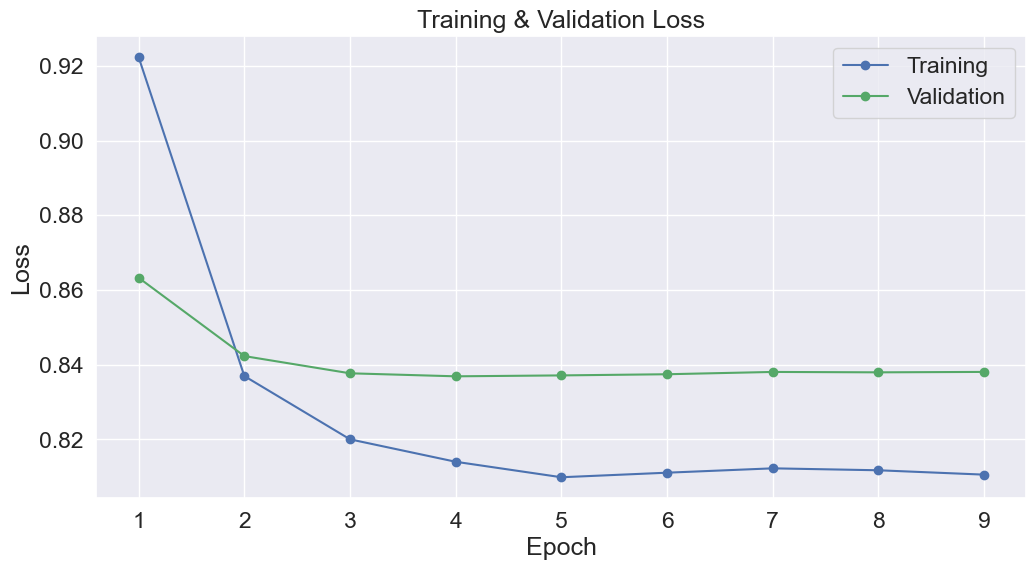

In [14]:
import seaborn as sns
import numpy as np

# plot results
def plot_results():
    # styling from seaborn.
    sns.set(style='darkgrid')
    # uncrease the plot size and font size.
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)

    # plot the learning curve.
    plt.plot(np.arange(1, len(avg_train_losses)+1), avg_train_losses, 'b-o', label="Training")
    plt.plot(np.arange(1, len(avg_train_losses)+1), avg_val_losses, 'g-o', label="Validation")

    # Label the plot.
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.xticks(list(range(1, len(avg_train_losses)+1)))

    return plt.show()


plot_results()

In [15]:
# Plotting the training and validation curves
#print (train_losses)

plt.plot(avg_train_losses, label='Training Loss')
plt.plot(avg_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'test' is not defined